# Eksperimen 5: OCR Pipeline (EasyOCR + Qwen 2.5)

This notebook implements the full pipeline for Experiment 5 using EasyOCR for text extraction and Qwen 2.5 (3B Instruct) for text correction/refinement.

**Key Improvements:**
- Robust Ollama response parsing.
- Incremental CSV saving to prevent data loss.
- Full dataset processing loop.


In [1]:
# Install required packages
%pip install easyocr ollama  opencv-python numpy pandas matplotlib seaborn

import os
import cv2
import matplotlib.pyplot as plt
import time
import glob
import numpy as np
import pandas as pd
import subprocess
import easyocr


Note: you may need to restart the kernel to use updated packages.


### DATASET

In [2]:
DATASET_DIR = r'f:/projek dosen/tutoring/Agentic Multimodal Tutor - SLL/dataset/UTS/SOAL2'
IMAGES_DIR = DATASET_DIR
GT_DIR = DATASET_DIR

# ===================== LIMIT PROCESSING =====================
USE_LIMIT = True  # Set to True to limit the number of processed files
LIMIT_COUNT = 50   # Number of files to process if limit is active

### CER

In [3]:
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def calculate_cer(reference, hypothesis):
    if not reference:
        return 0.0
    ref = " ".join(reference.split())
    hyp = " ".join(hypothesis.split())
    return levenshtein_distance(ref, hyp) / len(ref)

### GROUND TRUTH

In [4]:
def read_ground_truth(filename_base):
    path = os.path.join(GT_DIR, f"{filename_base}.txt")
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            return f.read().strip()
    return ""

### OCR INIT

In [5]:
print("Initializing EasyOCR...")
# Initialize EasyOCR Reader
ocr = easyocr.Reader(['en'], gpu=True) # Set gpu=False if no GPU


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Initializing EasyOCR...


Progress: |██████████████████████████████████████████████████| 100.0% Complete

### LLM CALL (AMAN)

In [6]:
# ===================== LLM CALL (ROBUST) =====================
def run_llm(prompt):
    # Run subprocess with robust encoding handling
    try:
        result = subprocess.run(
            ["ollama", "run", "qwen2.5:3b-instruct"],
            input=prompt,
            text=True,
            capture_output=True,
            encoding='utf-8',       # Ensure UTF-8 for I/O
            errors='replace'        # Replace chars that fail to encode/decode (fixes charmap error)
        )
        if result.returncode != 0:
            print(f"  [LLM ERROR] Exit Code: {result.returncode}")
            print(f"  [LLM STDERR] {result.stderr[:200]}...") # Print part of stderr
            return None
            
        return result.stdout.strip()
    except Exception as e:
        print(f"  [LLM EXCEPTION] {e}")
        return None


### FILE LIST

In [7]:
image_files = (
    glob.glob(os.path.join(IMAGES_DIR, "*.jpg")) +
    glob.glob(os.path.join(IMAGES_DIR, "*.png")) +
    glob.glob(os.path.join(IMAGES_DIR, "*.jpeg"))
)


results = []

# Apply Limit if Enabled
if USE_LIMIT and LIMIT_COUNT > 0:
    print(f"Limiting processing to first {LIMIT_COUNT} images.")
    image_files = image_files[:LIMIT_COUNT]

print(f"Found {len(image_files)} images.")


Limiting processing to first 50 images.
Found 50 images.


### MAIN LOOP

In [8]:
for idx, image_path in enumerate(image_files):
    filename = os.path.basename(image_path)
    filename_base = os.path.splitext(filename)[0]
    gt_text = read_ground_truth(filename_base)

    print(f"\nProcessing [{idx+1}/{len(image_files)}]: {filename}...")
    start_time = time.time()

    # ---------- OCR ----------
    # EasyOCR inference
    # returns list of (bbox, text, prob)
    try:
        ocr_result = ocr.readtext(image_path)
    except Exception as e:
        print(f"  [OCR ERROR] {e}")
        ocr_result = []

    extracted_lines = []
    bboxes = []
    
    for item in ocr_result:
        # item = (bbox_points, text, confidence)
        bbox_points = item[0]
        text_str = item[1]
        
        extracted_lines.append(text_str)
        bboxes.append(bbox_points)
    raw_text = "\n".join(extracted_lines)

    # ---------- VISUALIZATION & BBOX ----------
    if bboxes:
        img_vis = cv2.imread(image_path)
        if img_vis is not None:
            img_vis = cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB)
            for box in bboxes:
                box = np.array(box).astype(np.int32).reshape((-1, 1, 2))
                cv2.polylines(img_vis, [box], True, (255, 0, 0), 2)
            
            # Save Image
            os.makedirs(r'results/bbox', exist_ok=True)
            vis_path = os.path.join(r'results/bbox', f'vis_{filename}')
            plt.figure(figsize=(10, 10))
            plt.imshow(img_vis)
            plt.axis('off')
            plt.savefig(vis_path, bbox_inches='tight')
            plt.close()
            
            # Save Coords TXT
            txt_path = os.path.join(r'results/bbox', f'bbox_{filename_base}.txt')
            with open(txt_path, 'w', encoding='utf-8') as f:
                for i, box in enumerate(bboxes):
                    text = extracted_lines[i] if i < len(extracted_lines) else ''
                    f.write(f'{box} | {text}\n')

    # ---------- LLM ----------
    final_text = raw_text

    if raw_text.strip():
        if not os.path.exists("prompt_correction.txt"):
            print("  [ERROR] prompt_correction.txt not found!")
            continue
        with open("prompt_correction.txt", "r", encoding="utf-8") as f:
            prompt = f.read().replace("{OCR_TEXT}", raw_text)

        print("  [LLM] running...")
        llm_out = run_llm(prompt)

        if llm_out is None:
            print("  [LLM] timeout → skip")
            final_text = raw_text
        else:
            final_text = (
                llm_out
                .replace("```plaintext", "")
                .replace("```", "")
                .strip()
            )
            print("  [LLM] done")

    # ---------- METRIC ----------
    elapsed = time.time() - start_time
    cer_raw = calculate_cer(gt_text, raw_text)
    cer_refined = calculate_cer(gt_text, final_text)

    print(
        f"  OCR Length: {len(raw_text)} | "
        f"CER Raw: {cer_raw:.2%} | "
        f"CER Refined: {cer_refined:.2%} | "
        f"Time: {elapsed:.2f}s"
    )

    results.append({
        "filename": filename,
        "time": elapsed,
        "cer_raw": cer_raw,
        "cer_refined": cer_refined,
        "raw_text": raw_text,
        "final_text": final_text,
        "ground_truth": gt_text
    })

    # Save partial results incrementally
    if len(results) > 0:
        pd.DataFrame(results).to_csv('results/exp5_results.csv', index=False)

print("\nDONE. Total processed:", len(results))


Processing [1/50]: if4908_103012400180_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 169 | CER Raw: 74.66% | CER Refined: 66.97% | Time: 29.41s

Processing [2/50]: if4908_103012400221_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 116 | CER Raw: 35.20% | CER Refined: 37.60% | Time: 5.68s

Processing [3/50]: if4908_103012400283_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 124 | CER Raw: 0.00% | CER Refined: 0.00% | Time: 9.68s

Processing [4/50]: if4908_103012400355_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 188 | CER Raw: 57.75% | CER Refined: 48.13% | Time: 8.01s

Processing [5/50]: if4908_103012400374_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 78 | CER Raw: 76.47% | CER Refined: 76.47% | Time: 4.55s

Processing [6/50]: if4908_103012500007_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 204 | CER Raw: 44.22% | CER Refined: 55.78% | Time: 7.97s

Processing [7/50]: if4908_1030125000185_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 180 | CER Raw: 0.00% | CER Refined: 0.00% | Time: 5.45s

Processing [8/50]: if4908_103012500030_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 208 | CER Raw: 61.54% | CER Refined: 62.82% | Time: 11.18s

Processing [9/50]: if4908_103012500033_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 91 | CER Raw: 76.64% | CER Refined: 51.09% | Time: 5.73s

Processing [10/50]: if4908_103012500034_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 125 | CER Raw: 57.25% | CER Refined: 52.67% | Time: 6.81s

Processing [11/50]: if4908_103012500043_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 125 | CER Raw: 0.00% | CER Refined: 0.00% | Time: 6.33s

Processing [12/50]: if4908_103012500045_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 80 | CER Raw: 50.00% | CER Refined: 51.04% | Time: 4.85s

Processing [13/50]: if4908_103012500065_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 164 | CER Raw: 62.28% | CER Refined: 61.08% | Time: 7.58s

Processing [14/50]: if4908_103012500069_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 203 | CER Raw: 56.38% | CER Refined: 76.60% | Time: 10.54s

Processing [15/50]: if4908_103012500073_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 137 | CER Raw: 104.90% | CER Refined: 76.47% | Time: 3.82s

Processing [16/50]: if4908_103012500089_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 93 | CER Raw: 70.72% | CER Refined: 72.38% | Time: 5.28s

Processing [17/50]: if4908_103012500097_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 146 | CER Raw: 65.15% | CER Refined: 59.09% | Time: 6.94s

Processing [18/50]: if4908_103012500098_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 139 | CER Raw: 65.19% | CER Refined: 66.67% | Time: 7.26s

Processing [19/50]: if4908_103012500180_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 104 | CER Raw: 75.00% | CER Refined: 75.00% | Time: 6.29s

Processing [20/50]: if4908_103012500185_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 166 | CER Raw: 75.71% | CER Refined: 75.71% | Time: 8.95s

Processing [21/50]: if4908_103012500187_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 164 | CER Raw: 60.10% | CER Refined: 61.58% | Time: 5.64s

Processing [22/50]: if4908_103012500223_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 141 | CER Raw: 54.27% | CER Refined: 49.39% | Time: 7.15s

Processing [23/50]: if4908_103012500227_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 133 | CER Raw: 69.96% | CER Refined: 65.47% | Time: 5.91s

Processing [24/50]: if4908_103012500232_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 206 | CER Raw: 0.00% | CER Refined: 0.00% | Time: 9.93s

Processing [25/50]: if4908_103012500281_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 118 | CER Raw: 71.11% | CER Refined: 55.56% | Time: 6.18s

Processing [26/50]: if4908_103012500283_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 170 | CER Raw: 68.16% | CER Refined: 73.74% | Time: 7.77s

Processing [27/50]: if4908_103012500305_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 92 | CER Raw: 68.70% | CER Refined: 62.61% | Time: 4.57s

Processing [28/50]: if4908_103012500307_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 124 | CER Raw: 0.00% | CER Refined: 0.00% | Time: 5.83s

Processing [29/50]: if4908_103012500322_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 129 | CER Raw: 74.43% | CER Refined: 74.43% | Time: 7.81s

Processing [30/50]: if4908_103012500336_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 84 | CER Raw: 72.73% | CER Refined: 69.70% | Time: 5.28s

Processing [31/50]: if4908_103012500360_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 115 | CER Raw: 60.63% | CER Refined: 64.57% | Time: 6.35s

Processing [32/50]: if4908_103012500364_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 214 | CER Raw: 64.71% | CER Refined: 65.81% | Time: 12.38s

Processing [33/50]: if4908_103012500373_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 85 | CER Raw: 66.36% | CER Refined: 45.45% | Time: 5.30s

Processing [34/50]: if4908_103012500378_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 123 | CER Raw: 57.82% | CER Refined: 53.06% | Time: 5.08s

Processing [35/50]: if4908_103012500388_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 91 | CER Raw: 74.72% | CER Refined: 73.60% | Time: 5.76s

Processing [36/50]: if4908_103012500404_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 156 | CER Raw: 76.12% | CER Refined: 65.17% | Time: 5.87s

Processing [37/50]: if4908_103012530004_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 127 | CER Raw: 58.65% | CER Refined: 49.62% | Time: 6.43s

Processing [38/50]: if4908_1030125300069_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 184 | CER Raw: 0.00% | CER Refined: 0.00% | Time: 8.72s

Processing [39/50]: if4908_103012530014_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 56 | CER Raw: 74.16% | CER Refined: 93.26% | Time: 6.93s

Processing [40/50]: if4908_103012530019_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 83 | CER Raw: 77.65% | CER Refined: 63.53% | Time: 5.53s

Processing [41/50]: if4908_103012530043_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 152 | CER Raw: 68.48% | CER Refined: 66.30% | Time: 7.28s

Processing [42/50]: if4908_103012530046_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 84 | CER Raw: 64.66% | CER Refined: 49.14% | Time: 5.36s

Processing [43/50]: if4908_103012530052_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 288 | CER Raw: 123.12% | CER Refined: 63.58% | Time: 8.40s

Processing [44/50]: if4908_103012530054_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 227 | CER Raw: 46.85% | CER Refined: 46.85% | Time: 8.86s

Processing [45/50]: if4908_103012530062_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 131 | CER Raw: 64.75% | CER Refined: 71.31% | Time: 7.41s

Processing [46/50]: if4908_103012980008_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 131 | CER Raw: 0.00% | CER Refined: 0.00% | Time: 5.43s

Processing [47/50]: if4910_103012400004_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 215 | CER Raw: 0.00% | CER Refined: 0.00% | Time: 10.17s

Processing [48/50]: if4910_103012400057_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 160 | CER Raw: 63.20% | CER Refined: 60.80% | Time: 8.01s

Processing [49/50]: if4910_103012400149_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 136 | CER Raw: 0.00% | CER Refined: 0.00% | Time: 8.06s

Processing [50/50]: if4910_103012400267_nomor2.jpg...


f:\projek dosen\tutoring\tutoring-flow\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  [LLM] running...
  [LLM] done
  OCR Length: 146 | CER Raw: 0.00% | CER Refined: 0.00% | Time: 7.87s

DONE. Total processed: 50


Average Time: 7.4719s
Average CER (Raw): 53.81%
Average CER (Refined): 50.20%
Graph saved to results/cer_comparison.png


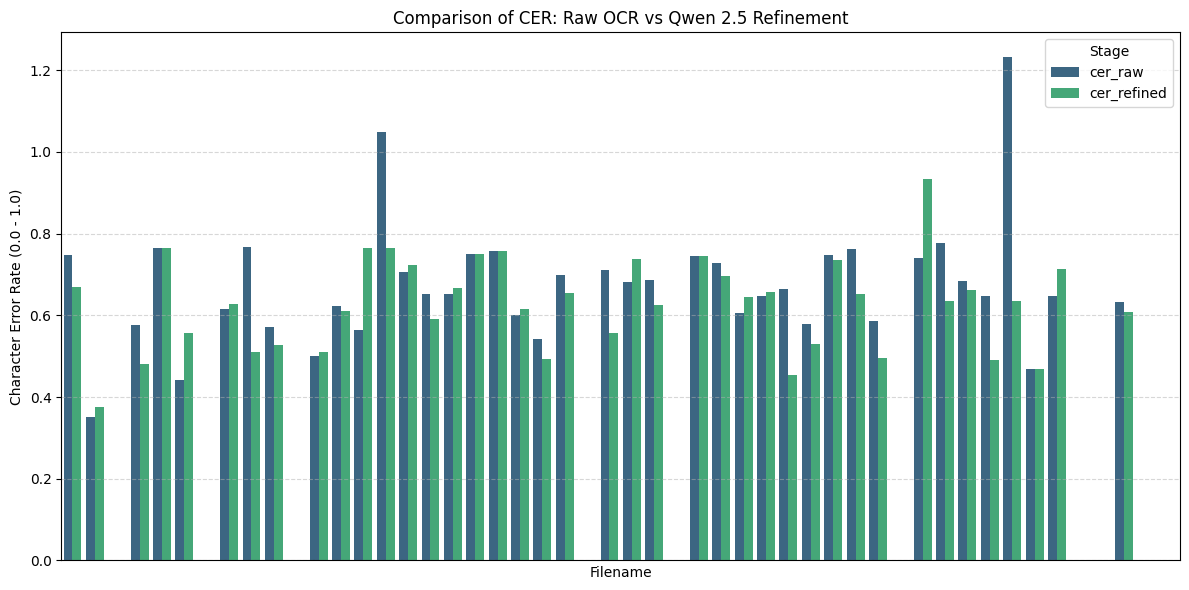

In [9]:
# ===================== VISUALIZE METRICS =====================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if results:
    df = pd.DataFrame(results)
    print(f"Average Time: {df['time'].mean():.4f}s")
    print(f"Average CER (Raw): {df['cer_raw'].mean():.2%}")
    print(f"Average CER (Refined): {df['cer_refined'].mean():.2%}")
    
    try:
        plt.figure(figsize=(12, 6))
        # Melt for seaborn
        df_melted = df.melt(id_vars=['filename'], value_vars=['cer_raw', 'cer_refined'], var_name='Stage', value_name='CER')
        
        sns.barplot(data=df_melted, x='filename', y='CER', hue='Stage', palette='viridis')
        plt.title('Comparison of CER: Raw OCR vs Qwen 2.5 Refinement')
        plt.xlabel('Filename')
        plt.ylabel('Character Error Rate (0.0 - 1.0)')
        # Too many x-labels might clutter, maybe strip?
        if len(df) > 20:
            plt.xticks([]) # Hide x labels if too many
        else:
            plt.xticks(rotation=45, ha='right')
            
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        
        save_path = 'results/cer_comparison.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Graph saved to {save_path}")
        plt.show()
    except Exception as e:
        print(f"Error plotting: {e}")
